In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from ultralytics import YOLO

In [2]:
def visualize_yolo(image_path, labels_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read YOLO labels
    with open(labels_path, 'r') as file:
        lines = file.readlines()

    # Draw bounding boxes on the image
    for line in lines:
        data = line.split()
        class_id = int(data[0])
        x, y, w, h = map(float, data[1:5])

        # Convert YOLO format to coordinates in the image
        img_h, img_w, _ = image.shape
        l = int((x - w/2) * img_w)
        r = int((x + w/2) * img_w)
        t = int((y - h/2) * img_h)
        b = int((y + h/2) * img_h)

        # Draw bounding box
        color = (0, 255, 0)  # Green color
        thickness = 2
        image = cv2.rectangle(image, (l, t), (r, b), color, thickness)

        # Display class label
        label = f"Class {class_id}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1
        text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        text_x = l
        text_y = t - 5 if t - 5 > 0 else t + 15
        image = cv2.putText(image, label, (text_x, text_y), font, font_scale, color, font_thickness)

    # Display the image with bounding boxes and labels
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def resize_with_padding(image, target_size=(224, 224)):
    h, w, _ = image.shape
    target_h, target_w = target_size

    # Calculate aspect ratios
    aspect_ratio_h = target_h / h
    aspect_ratio_w = target_w / w

    # Determine the new size while maintaining aspect ratio
    if aspect_ratio_h < aspect_ratio_w:
        new_h = target_h
        new_w = int(w * aspect_ratio_h)
    else:
        new_w = target_w
        new_h = int(h * aspect_ratio_w)

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h))

    # Create a canvas of the target size and place the resized image in the center
    canvas = np.zeros((target_h, target_w, 3), dtype=np.uint8)
    offset_h = (target_h - new_h) // 2
    offset_w = (target_w - new_w) // 2
    canvas[offset_h:offset_h+new_h, offset_w:offset_w+new_w] = resized_img

    return canvas

def process_images(input_image_folder, input_label_folder, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    n_viz = 10

    # Iterate through each image in the input folder
    for image_file in os.listdir(input_image_folder):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(input_image_folder, image_file)
            label_path = os.path.join(input_label_folder, image_file.replace(".jpg", ".txt"))

            # Read the YOLO labels
            with open(label_path, 'r') as file:
                lines = file.readlines()

            # Iterate through each line in the label file
            for line in lines:
                data = line.split()
                class_id = int(data[0])

                # If the class is 0, crop the image based on the bounding box
                if class_id == 0:
                    x, y, w, h = map(float, data[1:5])

                    img = cv2.imread(image_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_h, img_w, _ = img.shape

                    l = int((x - w/2) * img_w)
                    r = int((x + w/2) * img_w)
                    t = int((y - h/2) * img_h)
                    b = int((y + h/2) * img_h)

                    # Ensure the coordinates are within valid range
                    l = max(0, l)
                    r = min(img_w, r)
                    t = max(0, t)
                    b = min(img_h, b)

                    # Crop the image
                    cropped_img = img[t:b, l:r]

                    # Resize with padding to 224x224
                    resized_img = resize_with_padding(cropped_img, target_size=(224, 224))

                    # Save the resized image to the output folder
                    output_path = os.path.join(output_folder, 'pill')
                    os.makedirs(output_path, exist_ok=True)
                    output_path = os.path.join(output_path, image_file)
                    cv2.imwrite(output_path, cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))

                    # Plot original and resized images for a few examples
                    if n_viz > 0:
                        visualize_yolo(image_path, label_path)
                        plt.imshow(resized_img)
                        plt.axis('off')
                        plt.title('Resized Image')
                        plt.show()
                        n_viz -= 1

                    break  # Only consider the first class 0 bounding box

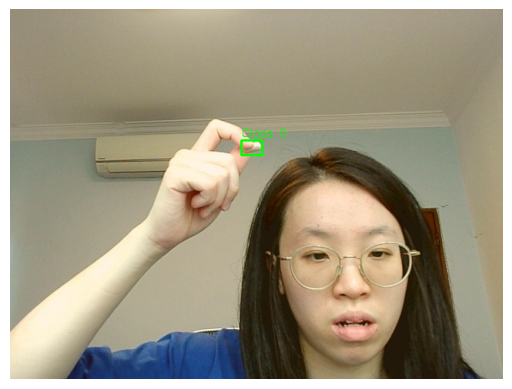

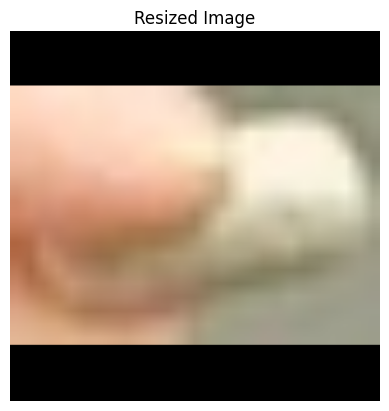

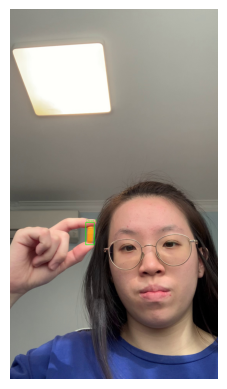

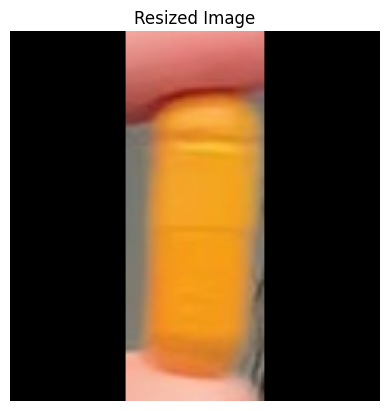

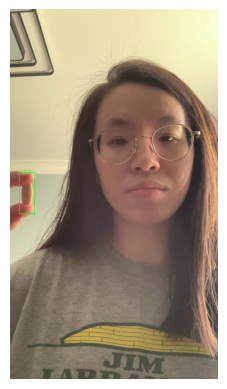

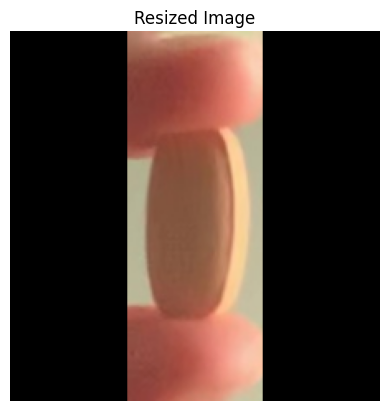

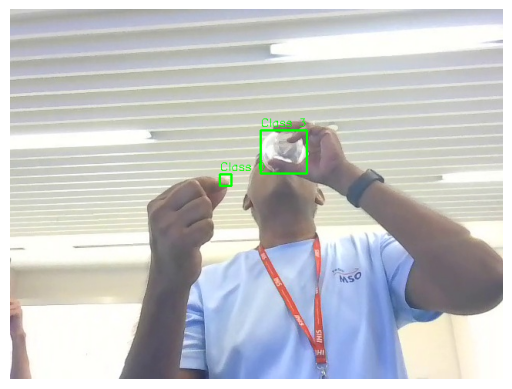

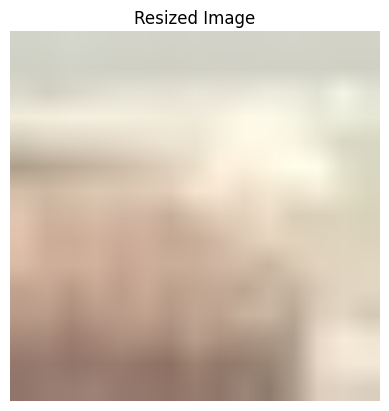

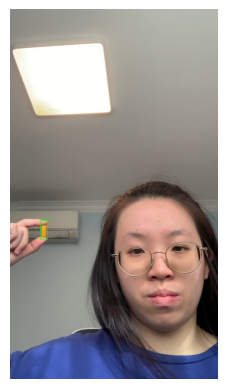

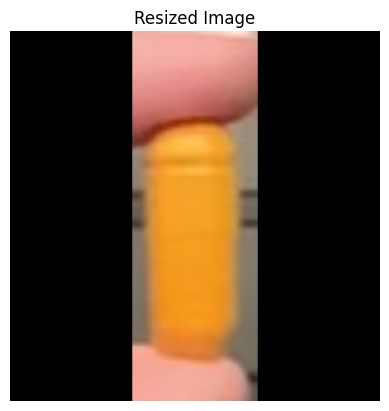

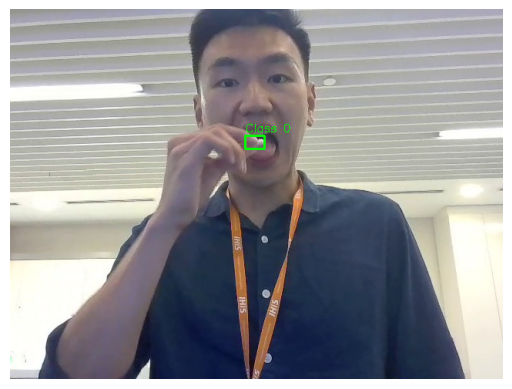

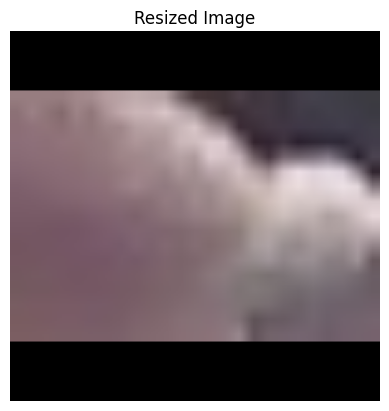

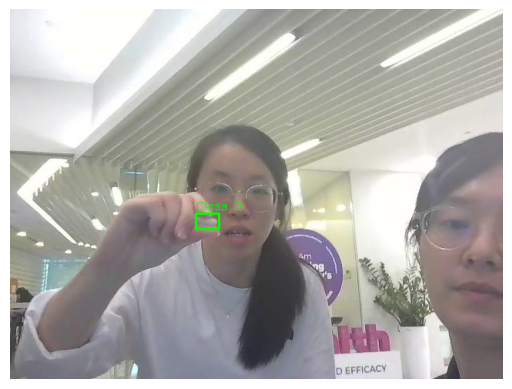

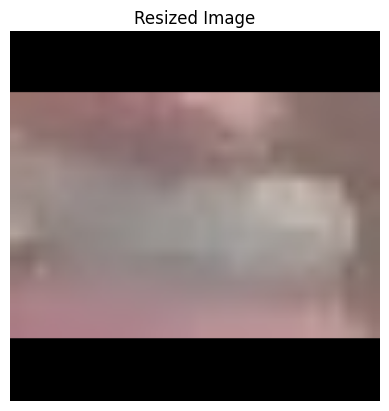

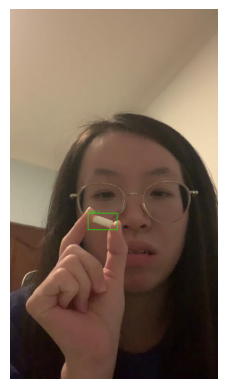

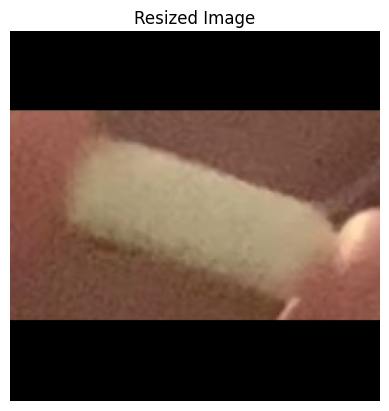

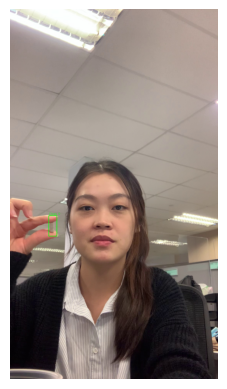

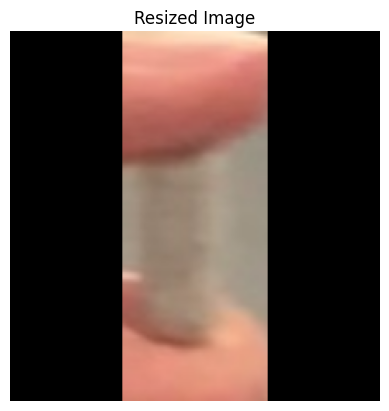

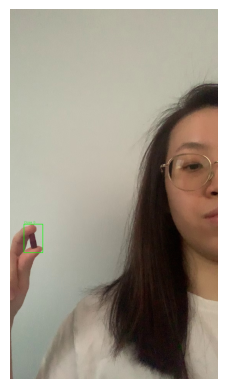

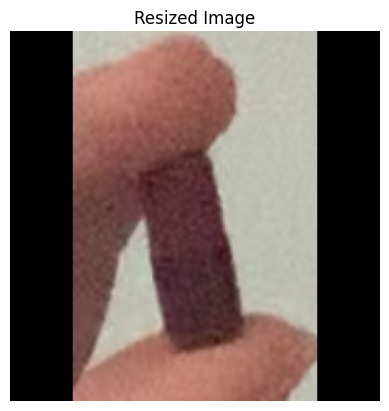

In [3]:
input_image_folder = os.path.join('..', 'data', 'raw', 'image')
input_label_folder = os.path.join('..', 'data', 'raw', 'label')
output_folder = os.path.join('..', 'data', 'processed', 'image')

process_images(input_image_folder, input_label_folder, output_folder)

In [4]:
def augment_pill_image(image):
    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-45, 45)),        # Random rotation
        iaa.Multiply((0.8, 1.2)),            # Brightness adjustment
        iaa.ContrastNormalization((0.8, 1.2)),  # Contrast adjustment
        iaa.Affine(scale=(0.8, 1.2)),        # Scaling
        iaa.Fliplr(0.5),                      # Horizontal flipping
        iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Additive Gaussian noise
        iaa.Affine(scale=(1.2, 1.5)),        # Zooming
    ], random_order=True)

    # Apply augmentation to the image
    augmented_images = [seq(image=image) for _ in range(10)]

    return augmented_images

In [6]:
def split_and_augment_data(input_folder, output_folder_train, output_folder_val, output_folder_test, test_size=0.1, val_size=0.2, random_state=42):
    # Ensure the output folders exist
    os.makedirs(output_folder_train, exist_ok=True)
    os.makedirs(output_folder_val, exist_ok=True)
    os.makedirs(output_folder_test, exist_ok=True)

    # Lists to store file paths and corresponding labels
    image_paths = []
    labels = []

    # Assuming you have a folder structure where each class has its own subfolder
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            class_label = class_folder  # Assuming class folders are named with class labels

            # Collect image paths and labels for each class
            class_image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(".jpg")]
            image_paths.extend(class_image_paths)
            labels.extend([class_label] * len(class_image_paths))

    print(f'images: {image_paths}, num of images: {len(image_paths)}, label: {labels}')

    # Shuffle the data to ensure randomness
    image_paths, labels = shuffle(image_paths, labels, random_state=random_state)

    # Split the dataset into train, validation, and test sets using stratified sampling
    train_paths, remaining_paths, train_labels, remaining_labels = train_test_split(image_paths, labels, test_size=val_size+test_size, stratify=labels, random_state=random_state)
    val_paths, test_paths, val_labels, test_labels = train_test_split(remaining_paths, remaining_labels, test_size=(test_size/(val_size+test_size)), stratify=remaining_labels, random_state=random_state)

    print(f'size of train: {len(train_paths)/len(image_paths)}, size of val: {len(val_paths)/len(image_paths)}, size of test: {len(test_paths)/len(image_paths)}')

    # Iterate through each image in the train set
    for image_path, label in zip(train_paths, train_labels):
        # Read the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Augment the image
        augmented_images = augment_pill_image(img)

        output_path = os.path.join(output_folder_train, str(label))
        os.makedirs(output_path, exist_ok=True)

        # Save augmented images to the output folder
        base_filename = os.path.split(image_path)[1]
        base_filename = os.path.splitext(base_filename)[0]
        for i, augmented_img in enumerate(augmented_images):
            file_path = os.path.join(output_path, f"{base_filename}_aug_{i + 1}.jpg")
            cv2.imwrite(file_path, cv2.cvtColor(augmented_img, cv2.COLOR_BGR2RGB))

    # Copy validation and test images to their respective folders without augmentation
    for image_path, label in zip(val_paths, val_labels):
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(output_folder_val, str(label))
        os.makedirs(output_path, exist_ok=True)
        output_path = os.path.join(output_path, f"{base_filename}.jpg")
        cv2.imwrite(output_path, cv2.imread(image_path))

    for image_path, label in zip(test_paths, test_labels):
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(output_folder_test, str(label))
        os.makedirs(output_path, exist_ok=True)
        output_path = os.path.join(output_path, f"{base_filename}.jpg")
        cv2.imwrite(output_path, cv2.imread(image_path))

In [7]:
input_folder = os.path.join('..', 'data', 'processed', 'image')
output_folder_train = os.path.join('..', 'data', 'processed', 'train')
output_folder_val = os.path.join('..', 'data', 'processed', 'val')
output_folder_test = os.path.join('..', 'data', 'processed', 'test')

split_and_augment_data(input_folder, output_folder_train, output_folder_val, output_folder_test)

images: ['../data/processed/image/pill/24julyellow_0051.jpg', '../data/processed/image/pill/IMG_938224julpill_0041.jpg', '../data/processed/image/pill/train10.jpg', '../data/processed/image/pill/3074pilltrack23jun.jpg', '../data/processed/image/pill/IMG_938224julpill_0531.jpg', '../data/processed/image/pill/3469pilltrack23jun.jpg', '../data/processed/image/pill/058516june.jpg', '../data/processed/image/pill/0155_7june.jpg', '../data/processed/image/pill/15mar_660.jpg', '../data/processed/image/pill/images725.jpg', '../data/processed/image/pill/IMG_938724julpill_2696.jpg', '../data/processed/image/pill/1634pilltrack21jun.jpg', '../data/processed/image/pill/0141_7june.jpg', '../data/processed/image/pill/IMG_938624julpill_1548.jpg', '../data/processed/image/pill/072420231555236197.jpg', '../data/processed/image/pill/230716june.jpg', '../data/processed/image/pill/IMG_938724julpill_2906.jpg', '../data/processed/image/pill/images651.jpg', '../data/processed/image/pill/HFC2270.jpg', '../data/

/Users/chuamingfeng/Desktop/Synapxe/pill_classification/pilldetection/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [9]:
!yolo classify train model='../model/yolov8n-cls.pt' data='/Users/chuamingfeng/Desktop/Synapxe/pill_classification/data/processed'

New https://pypi.org/project/ultralytics/8.1.1 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2 CPU (Intel Core(TM) i5-1038NG7 2.00GHz)
engine/trainer: task=classify, mode=train, model=../model/yolov8n-cls.pt, data=/Users/chuamingfeng/Desktop/Synapxe/pill_classification/data/processed, epochs=100, time=None, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c